In [1]:
import pandas as pd
from pandas import datetime
#import datetime
import matplotlib
import numpy as np
#import warnings
#import itertools
#import statsmodels.api as sm
from pandas import Series
from pandas import datetime
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
#plt.style.use('fivethirtyeight')
%matplotlib inline
 
production=pd.read_pickle("./processed/production_all_dates_and_variables.pkl")
keep_these=['Wind_KWH',
            'Solar_KWH',
            'Wind_Speed_AT_WINDFARM',
            'Solar_Elevation',
            'Cloud_Cover_Fraction',
            'Dew_Point',
            'Humidity_Fraction',
            'Precipitation',
            'Pressure',
            'Temperature',
            'Visibility',
            'Wind_Speed_AT_SOLARRAY']
production=production[keep_these]
#fill the date and time gaps
production = production.resample("60min").asfreq()
print(production.head(25))


                     Wind_KWH  Solar_KWH  Wind_Speed_AT_WINDFARM  \
Time                                                               
2010-01-04 15:00:00       NaN   14186.16                     NaN   
2010-01-04 16:00:00       NaN    5898.00                     NaN   
2010-01-04 17:00:00       NaN        NaN                     NaN   
2010-01-04 18:00:00       NaN        NaN                     NaN   
2010-01-04 19:00:00       NaN        NaN                     NaN   
2010-01-04 20:00:00       NaN        NaN                     NaN   
2010-01-04 21:00:00       NaN        NaN                     NaN   
2010-01-04 22:00:00       NaN        NaN                     NaN   
2010-01-04 23:00:00       NaN        NaN                     NaN   
2010-01-05 00:00:00       NaN        NaN                     NaN   
2010-01-05 01:00:00       NaN        NaN                     NaN   
2010-01-05 02:00:00       NaN        NaN                     NaN   
2010-01-05 03:00:00       NaN        NaN        

In [2]:
"""
Implement an imputation scheme for each variable.

Dependent Variables - no imputation
solar - if nighttime, zero
=========================================
'Temperature', - Average
'Visibility', - Average
'Wind_Speed_AT_SOLARRAY' - Average

""" 

solar_prod=production['Solar_KWH']
solar_prod_by_hour = solar_prod.resample("60min").sum().to_frame('Solar_KWH')
solar_prod_by_hour.to_pickle("./processed/solar_prod_by_hour.pkl")

independent_vars=['Temperature',
                  'Visibility',
                  'Wind_Speed_AT_SOLARRAY']

indep_vars=production[independent_vars]
for field in independent_vars:
    tmp=pd.DataFrame(data=indep_vars[field])
    tmp.dropna(axis=0, inplace=True)
    tmp=tmp.loc[tmp[field]!='nan'] 
    tmp=pd.to_numeric(tmp[field], downcast='float')
    solar_prod_by_hour=solar_prod_by_hour.join(tmp, how='left', sort=True)
    
# Now, we need to interpolate missing values.

def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`, courtesy of StackOVerflow:
    https://stackoverflow.com/questions/36455083/working-with-nan-values-in-matplotlib
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan
    return filled


columns={}
dates=solar_prod_by_hour.index.values
columns['Date']=dates
for field in list(solar_prod_by_hour):
    raw=solar_prod_by_hour[field].values
    filled = interpolate_gaps(raw, limit=2)
    columns[field]=filled

solar_prod_by_hour_fnl=pd.DataFrame.from_dict(columns)
solar_prod_by_hour_fnl.set_index('Date', inplace=True)
solar_prod_by_hour_fnl=solar_prod_by_hour_fnl.fillna(0)
solar_prod_by_hour_fnl.to_pickle("./processed/solar_prod_by_hour_w_interpolation.pkl")
print(solar_prod_by_hour_fnl.head(25))

                     Solar_KWH  Temperature  Visibility  \
Date                                                      
2010-01-04 15:00:00   14186.16    -3.900000   16.093000   
2010-01-04 16:00:00    5898.00    -3.300000   16.093000   
2010-01-04 17:00:00       0.00     0.000000    0.000000   
2010-01-04 18:00:00       0.00     0.000000    0.000000   
2010-01-04 19:00:00       0.00     0.000000    0.000000   
2010-01-04 20:00:00       0.00     0.000000    0.000000   
2010-01-04 21:00:00       0.00     0.000000    0.000000   
2010-01-04 22:00:00       0.00     0.000000    0.000000   
2010-01-04 23:00:00       0.00     0.000000    0.000000   
2010-01-05 00:00:00       0.00     0.000000    0.000000   
2010-01-05 01:00:00       0.00     0.000000    0.000000   
2010-01-05 02:00:00       0.00     0.000000    0.000000   
2010-01-05 03:00:00       0.00     0.000000    0.000000   
2010-01-05 04:00:00       0.00     0.000000    0.000000   
2010-01-05 05:00:00       0.00     0.000000    0.000000 

In [3]:
solar_prod=solar_prod_by_hour_fnl
#solar_prod['Month']=solar_prod.index.month
#solar_prod['Day']=solar_prod.index.day
solar_prod['Hour']=solar_prod.index.hour
print(solar_prod.head())

                     Solar_KWH  Temperature  Visibility  \
Date                                                      
2010-01-04 15:00:00   14186.16         -3.9      16.093   
2010-01-04 16:00:00    5898.00         -3.3      16.093   
2010-01-04 17:00:00       0.00          0.0       0.000   
2010-01-04 18:00:00       0.00          0.0       0.000   
2010-01-04 19:00:00       0.00          0.0       0.000   

                     Wind_Speed_AT_SOLARRAY  Hour  
Date                                               
2010-01-04 15:00:00                     5.7    15  
2010-01-04 16:00:00                     3.6    16  
2010-01-04 17:00:00                     0.0    17  
2010-01-04 18:00:00                     0.0    18  
2010-01-04 19:00:00                     0.0    19  


In [4]:
# Trying the approach of letting the model learn about time.
corr=solar_prod.corr()
corr.style.background_gradient().set_precision(2)

,Solar_KWH,Temperature,Visibility,Wind_Speed_AT_SOLARRAY,Hour
Solar_KWH,1,0.36,0.42,0.32,0.14
Temperature,0.36,1,0.48,0.25,0.12
Visibility,0.42,0.48,1,0.59,0.034
Wind_Speed_AT_SOLARRAY,0.32,0.25,0.59,1,0.093
Hour,0.14,0.12,0.034,0.093,1


RMSE: 44,987.36840219503
R^2: 0.22911769063271503


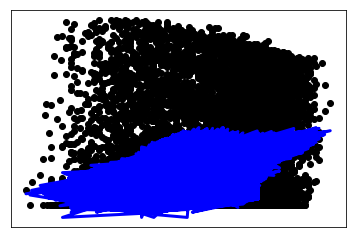

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm

X=solar_prod[['Temperature', 'Visibility','Wind_Speed_AT_SOLARRAY','Hour']].values
y=solar_prod['Solar_KWH'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

#print('Coefficients: \n', regr.coef_)
print("RMSE: {:,}".format((mean_squared_error(y_test, y_pred))**.5))
print('R^2: {:,}'.format(r2_score(y_test, y_pred)))

#print("x_test: {} y_test: {} y_pred: {}".format(len(X_test), len(y_test), len(y_pred)))
plt.scatter(X_test[:,0], y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xticks(())
plt.yticks(())

plt.show()

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                           n_estimators=300,
                           random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

print("Decision Tree Regressor: {:,}".format((mean_squared_error(y, y_1)**.5)))
print('Decision Tree R^2: {:,}'.format(r2_score(y, y_1)))

print("Adaboost Regressor: {:,}".format((mean_squared_error(y, y_2))**.5))
print('Adaboost R^2: {:,}'.format(r2_score(y, y_2)))



Decision Tree Regressor: 29,630.876462675405
Decision Tree R^2: 0.6608686213240705
Adaboost Regressor: 28,496.117026521304
Adaboost R^2: 0.6863463461732603


In [9]:
new_prod=pd.read_pickle("./processed/production_all_dates_and_variables.pkl")
keep_these=['Solar_KWH',
            'Temperature',
            'Visibility',
            'Wind_Speed_AT_SOLARRAY']
new_prod=new_prod[keep_these]
new_prod=new_prod.dropna(how='any')
#print(new_prod.head())

new_prod['Hour']=new_prod.index.hour

#for field in list(new_prod):
#    print("Field: {} min: {} max: {}".format(field, min(new_prod[field]), max(new_prod[field])))
#    print("Field: {} Type: {}".format(field, new_prod[field].dtype))

    
#nantemp=new_prod.loc[new_prod['Temperature']=='nan']
#print(nantemp.head())


    

Minimum Solar_KWH value: 2 Maximum Solar_KWH value: 164495 Interval: 1645
Threshold Value: 21388 Maximum RMSE: 0.41682386971571084


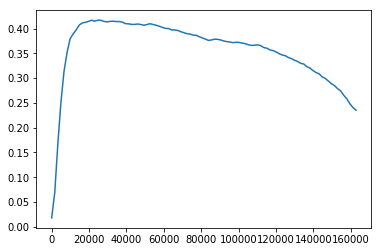

Threshold Value: 83898 Maximum R2: 0.39236804068204223


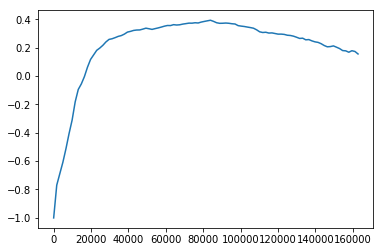

In [10]:
mean_kwh=int(round(new_prod['Solar_KWH'].mean(),0))
min_kwh=int(round(new_prod['Solar_KWH'].min() * 1.2,0))
max_kwh=int(round(new_prod['Solar_KWH'].max() * 0.8,0))
interval=int(round((max_kwh-min_kwh)/100,0))
#print(min_kwh, max_kwh, interval)

def get_series(series):
    values = pd.DataFrame(series.values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    # Create lagged dataset
    X = dataframe.values
    train_size = int(len(X) * 0.66)
    train, test = X[1:train_size], X[train_size:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]
    return train_X, train_y, test_X, test_y
    

# persistence model
def model_persistence(x):
    return x

print("Minimum Solar_KWH value: {} Maximum Solar_KWH value: {} Interval: {}".format(min_kwh, max_kwh, interval))
mse_store={}
var_store={}

for kwh in range(min_kwh+1, max_kwh-1, interval):
    new_prod['Thresh'] = np.where(new_prod['Solar_KWH']>=kwh, True, False)
    #print(new_prod['Thresh'].head())
    tmp_series=new_prod['Thresh']
    train_X, train_y, test_X, test_y = get_series(tmp_series)
    predictions = list()
    for x in test_X:
        yhat = model_persistence(x)
        predictions.append(yhat)
    test_score = mean_squared_error(test_y, predictions)**.5
    variance_score=r2_score(test_y, predictions)
    #print('Value: {} Test MSE: {}'.format(kwh, test_score))
    mse_store[kwh]=test_score
    var_store[kwh]=variance_score
#print(mse_store)

# from: https://stackoverflow.com/questions/37266341/plotting-a-python-dict-in-order-of-key-values
lists = sorted(mse_store.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

key_max = max(mse_store.keys(), key=(lambda k: mse_store[k]))
print("Threshold Value: {} Maximum RMSE: {}".format(key_max, mse_store[key_max]))
plt.plot(x, y)
plt.figsize=(15, 8)
plt.show()


lists = sorted(var_store.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

key_max = max(var_store.keys(), key=(lambda k: var_store[k]))
print("Threshold Value: {} Maximum R2: {}".format(key_max, var_store[key_max]))
plt.plot(x, y)
plt.figsize=(15, 8)
plt.show()

In [47]:
kwh_threshold=83898
tmp_prod=new_prod

values = pd.DataFrame(tmp_prod['Solar_KWH'].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']

tmp_prod['Prior_KWH']=dataframe['t-1'].values
tmp_prod['Thresh']=np.where(tmp_prod['Prior_KWH']>=kwh_threshold, True, False)
tmp_prod['Target']=np.where(tmp_prod['Solar_KWH']>=kwh_threshold, True, False)
    
print(tmp_prod.head())

                     Solar_KWH Temperature Visibility Wind_Speed_AT_SOLARRAY  \
Time                                                                           
2010-01-04 15:00:00   14186.16        -3.9     16.093                    5.7   
2010-01-04 16:00:00    5898.00        -3.3     16.093                    3.6   
2010-01-05 09:00:00   12421.86        -6.1      8.047                    3.1   
2010-01-05 10:00:00   14210.46        -5.0     16.093                    4.1   
2010-01-05 11:00:00   14723.64        -4.4     16.093                    3.6   

                     Hour  Thresh  Prior_KWH  Target  kwh_binned  kwh_bin_mid  
Time                                                                           
2010-01-04 15:00:00    15   False        NaN   False           4        10281  
2010-01-04 16:00:00    16   False   14186.16   False           2         2057  
2010-01-05 09:00:00     9   False    5898.00   False           4        10281  
2010-01-05 10:00:00    10   False   124

In [48]:
mean_kwh=int(round(tmp_prod['Solar_KWH'].mean(),0))
min_kwh=int(round(tmp_prod['Solar_KWH'].min() * 1.0,0))
max_kwh=int(round(tmp_prod['Solar_KWH'].max() * 1.0,0))
interval=int(round((max_kwh-min_kwh)/50,0))

bins=[]
midvals={}
key_index=1

def find_mid_bin(kwh, interval):
    return(kwh-int(round(interval/2, 0)))

for kwh_val in range(min_kwh, max_kwh, interval):
    bins.append(kwh_val)
    midvals[key_index]=find_mid_bin(kwh_val, interval)
    key_index+=1

#print(midvals)
#print(bins)

def get_midvals(x):
    return midvals[x]

tmp_prod['kwh_binned'] = np.searchsorted(bins, tmp_prod['Solar_KWH'].values)
#tmp_prod['kwh_bin_mid']=tmp_prod['kwh_binned']
tmp_vals=tmp_prod['kwh_binned'].apply(get_midvals)
tmp_prod['kwh_bin_mid']=tmp_vals
#tmp_prod['kwh_bin_mid'].apply(lambda x: midvals[x])
#=midvals[tmp_prod['kwh_binned']]
print(tmp_prod[['Solar_KWH', 'kwh_binned', 'kwh_bin_mid']].head())


tmp_prod=tmp_prod.dropna(how='any')

tmp_prod=tmp_prod.loc[tmp_prod['Temperature'] != 'nan']
tmp_prod['Temperature']=tmp_prod['Temperature'].astype('float64')
tmp_prod=tmp_prod.loc[tmp_prod['Visibility'] != 'nan']
tmp_prod['Visibility']=tmp_prod['Visibility'].astype('float64')
tmp_prod=tmp_prod.loc[tmp_prod['Wind_Speed_AT_SOLARRAY'] != 'nan']
tmp_prod['Wind_Speed_AT_SOLARRAY']=tmp_prod['Wind_Speed_AT_SOLARRAY'].astype('float64')
#tmp_prod=tmp_prod.loc[tmp_prod['Prior_KWH'] != 'nan']
tmp_prod['Prior_KWH']=tmp_prod['Prior_KWH'].astype('float64')

                     Solar_KWH  kwh_binned  kwh_bin_mid
Time                                                   
2010-01-04 15:00:00   14186.16           4        10281
2010-01-04 16:00:00    5898.00           2         2057
2010-01-05 09:00:00   12421.86           4        10281
2010-01-05 10:00:00   14210.46           4        10281
2010-01-05 11:00:00   14723.64           4        10281


           0
0  -2.550105
1   7.069220
2   5.808016
3   9.638940
4  14.294881
RMSE (Bins): 5.865962119015603
R^2: 0.8130168542531317


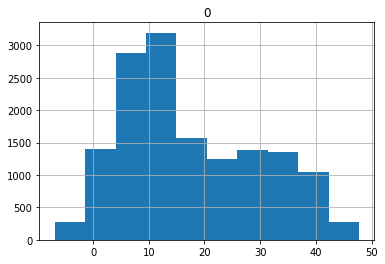

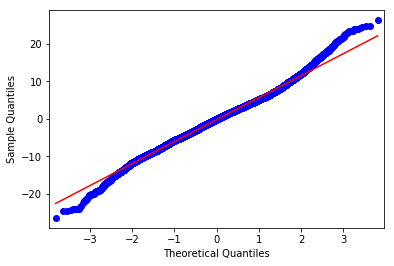

In [55]:
import statsmodels.api as sm
#from sklearn.metrics import confusion_matrix

#X=tmp_prod[['Temperature', 'Visibility','Wind_Speed_AT_SOLARRAY','Hour', 'Thresh']].values
X=tmp_prod[['Temperature', 'Visibility','Wind_Speed_AT_SOLARRAY','Hour', 'Prior_KWH']].values
#y=tmp_prod['Target'].values
y=tmp_prod['kwh_binned'].values
y_kwh=tmp_prod['Solar_KWH'].values
y_mid=tmp_prod['kwh_bin_mid'].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)

n_split=4000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]
y_test_kwh=y_kwh[:n_split]

regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

tmp=pd.DataFrame(y_pred)
print(tmp.head())
tmp.hist()
#y_pred_kwh=tmp.apply(get_midvals)

#print('Coefficients: \n', regr.coef_)
print("RMSE (Bins): {:,}".format((mean_squared_error(y_test, y_pred))**.5))
#print("RMSE (KWH): {:,}".format((mean_squared_error(y_test_kwh, y_pred_kwh))**.5))
print('R^2: {:,}'.format(r2_score(y_test, y_pred)))

resid = y_test-y_pred

sm.qqplot(resid, line='s');

In [57]:
tmp_prod['Hour_Cat']=tmp_prod['Hour'].astype('category')
tmp_prod['kwh_binned']=tmp_prod['kwh_binned'].astype('category')
#print(list(tmp_prod))
print(tmp_prod['Hour_Cat'].dtype)
print(tmp_prod['Target'].dtype)
print(tmp_prod['kwh_binned'].dtype)

category
bool
category


In [61]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
rng = np.random.RandomState(1)

X=tmp_prod[['Temperature', 'Visibility','Wind_Speed_AT_SOLARRAY','Hour', 'Prior_KWH']].values
#X=tmp_prod[['Visibility', 'Hour', 'Thresh']].values
#X=tmp_prod[['Visibility', 'Hour_Cat', 'Prior_KWH']].values

#y=tmp_prod['Target'].values
y=tmp_prod['kwh_binned'].astype('category').values

n_split=4000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)

# Fit decision tree model

dt = DecisionTreeClassifier(random_state=rng)
dt.fit(X_train, y_train)

# Predict
y_pred = dt.predict(X_test)

print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           1       0.31      0.26      0.29       407
           2       0.34      0.40      0.37      1042
           3       0.25      0.24      0.24      1006
           4       0.19      0.18      0.18       822
           5       0.17      0.14      0.15       841
           6       0.20      0.18      0.19       663
           7       0.10      0.10      0.10       493
           8       0.07      0.05      0.06       390
           9       0.08      0.07      0.07       353
          10       0.05      0.06      0.05       321
          11       0.04      0.04      0.04       310
          12       0.06      0.07      0.06       336
          13       0.11      0.09      0.10       312
          14       0.10      0.11      0.11       358
          15       0.09      0.13      0.10       352
          16       0.07      0.06      0.06       304
          17       0.05      0.06      0.05       246
          18       0.06    

/home/srummel/anaconda2/envs/csc481/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/srummel/anaconda2/envs/csc481/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/srummel/anaconda2/envs/csc481/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
rng = np.random.RandomState(1)

#X=tmp_prod[['Temperature', 'Visibility','Wind_Speed_AT_SOLARRAY','Hour', 'Thresh']].values
#X=tmp_prod[['Visibility', 'Hour', 'Thresh']].values
#X=tmp_prod[['Visibility', 'Hour_Cat', 'Thresh']].values


#y=tmp_prod['kwh_binned'].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=rng)

# Fit classifier model

regr_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

regr_2.fit(X_train, y_train)
# Predict
y_pred = regr_2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       407
           2       0.00      0.00      0.00      1042
           3       0.09      0.33      0.14      1006
           4       0.00      0.00      0.00       822
           5       0.10      0.24      0.14       841
           6       0.12      0.30      0.17       663
           7       0.02      0.00      0.01       493
           8       0.04      0.06      0.05       390
           9       0.12      0.02      0.04       353
          10       0.02      0.05      0.03       321
          11       0.00      0.00      0.00       310
          12       0.00      0.00      0.00       336
          13       0.08      0.13      0.10       312
          14       0.00      0.00      0.00       358
          15       0.00      0.00      0.00       352
          16       0.00      0.00      0.00       304
          17       0.04      0.00      0.01       246
          18       0.00    

/home/srummel/anaconda2/envs/csc481/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/srummel/anaconda2/envs/csc481/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/srummel/anaconda2/envs/csc481/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
# Logistic Regression
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

#X=tmp_prod[['Temperature', 'Visibility','Wind_Speed_AT_SOLARRAY','Hour', 'Thresh']].values
#X=tmp_prod[['Visibility', 'Hour', 'Thresh']].values
#X=tmp_prod[['Visibility', 'Hour_Cat', 'Thresh']].values
#y=tmp_prod['Target'].values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)

regr = LogisticRegression(random_state=0,
                          solver='lbfgs',
                          multi_class='multinomial')

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

#print("Logistic Regression Regressor: {:,}".format((mean_squared_error(y_test, y_pred))**.5))
#print('R^2: {:,}'.format(r2_score(y_test, y_pred)))
#resid = y_test-y_pred
print("Logistic Regression Model Score (Test): {}".format(regr.score(X_test, y_test)))
sm.qqplot(resid, line='s');
print(classification_report(y_test, y_pred))
print(regr.coef_)

In [ ]:
# y=(0.08222031 * Visibility)
#  -(0.13010298 * Hour)
#  +(2.01934606 * Threshold)
print(tmp_prod['Hour'].unique())
print(tmp_prod['Hour'].median())
tmp_prod['Hour'].hist();

In [ ]:
# Logistic Regression
median_hour=tmp_prod['Hour'].median()
tmp_prod['Adj_Hour']=tmp_prod['Hour'] % median_hour

print(tmp_prod['Adj_Hour'].unique())

#X=tmp_prod[['Visibility', 'Hour', 'Thresh']].values
X=tmp_prod[['Visibility', 'Adj_Hour', 'Thresh']].values
y=tmp_prod['Target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

regr = LogisticRegression(random_state=0,
                          solver='lbfgs',
                          multi_class='multinomial')

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

#print("Logistic Regression Regressor: {:,}".format((mean_squared_error(y_test, y_pred))**.5))
#print('R^2: {:,}'.format(r2_score(y_test, y_pred)))
#resid = y_test-y_pred
print("Logistic Regression Model Score (Test): {}".format(regr.score(X_test, y_test)))
sm.qqplot(resid, line='s');
print(classification_report(y_test, y_pred))
print(regr.coef_)